In [13]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import math
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# movie_info.csv is in the drive due to the file size

###  Link : https://drive.google.com/file/d/15jEoMguvEfibrWNSykJjcZMI7eSEO7vo/view?usp=sharing

In [4]:
df1 = pd.read_csv('movie_info.csv')
df = df1

In [ ]:
for i in df.index:
    movie_name = df[i]['Title']
    movie_name = movie_name.title()
    movie = ""
    for i in range(len(movie_name)):
        if movie_name[i] == ' ':
            movie += '_'
        else:
            movie += movie_name[i]
    df.loc[i]['Wiki Page'] = movie

In [ ]:
def func(pl):
    while(1):
        i = pl.find('[[')
        if(i==-1):
            break
        j = pl.find(']]')
        pl = pl[:i] + pl[j+2:]
    while(1):
        i = pl.find('{{')
        if(i==-1):
            break
        j = pl.find('}}')
        pl = pl[:i] + pl[j+2:]
    while(1):
        i = pl.find('(')
        if(i==-1):
            break
        j = pl.find(')')
        pl = pl[:i] + pl[j+2:]
    while(1):
        i = pl.find('<')
        if(i==-1):
            break
        j = pl.find('>')
        pl = pl[:i] + pl[j+2:]
    p = ''
    for i in pl:
        if(i!='\n'):
            p += i
    return p

In [60]:
for i in df.index:
    url = df.loc[i]['Wiki Page']
    html = urlopen(url) 
    soup = BeautifulSoup(html, 'html.parser')
    try:
        url = "https://en.wikipedia.org"+soup.find('a',{'title':'Edit section: Plot'})['href']
    except:
        continue
    html = urlopen(url) 
    soup = BeautifulSoup(html, 'html.parser')
    plot = soup.find('textarea').text
    try:
        i = plot.index('==')
        plot = plot[i+len('=='):]
        i = plot.index('==')
        plot = plot[i+len('=='):]
    except:
        plot = plot
        df.loc[i,'Plot'] = 'a'
    plot = func(plot)
    df.loc[i,'Plot'] = plot
df = df[df['Plot']!='a']
df.to_csv('movie_info.csv',index = False)

In [89]:
df = df[df["Release Year"]>1970]

In [90]:
action = df[df.apply(lambda x: "action" == x['Genre'].lower(),axis = 1)]
drama = df[df.apply(lambda x: "drama" == x['Genre'].lower() , axis=1)]
fantasy = df[df.apply(lambda x: "fantasy" == x['Genre'].lower(),axis = 1)]
horror = df[df.apply(lambda x: "horror" == x['Genre'].lower(),axis = 1)]
sci_fi = df[df.apply(lambda x: "sci" == x['Genre'].lower(),axis = 1)]
romance = df[df.apply(lambda x: "romance" == x['Genre'].lower() or "romantic"  in x['Genre'].lower(),axis = 1)]
thriller = df[df.apply(lambda x: "thriller" == x['Genre'] or "mystery" == x['Genre'].lower(),axis = 1)]
crime = df[df.apply(lambda x: "crime" == x['Genre'].lower(),axis = 1)]
adventure = df[df.apply(lambda x: "adventure" == x['Genre'].lower(),axis = 1)]

In [8]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~0123456789'''


In [22]:
# for i in thriller.index:
#     plot = thriller.loc[i,'Plot']
#     tagged_sentence = nltk.tag.pos_tag(plot.split())
#     edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
#     example_sentence = ' '.join(edited_sentence)
#     no_punct = ""
#     for char in example_sentence:
#        if char not in punctuations:
#            no_punct = no_punct + char
#        else:
#             no_punct += ' '
#     example_sentence = no_punct
#     tagged_sentence = nltk.tag.pos_tag(example_sentence.split())
#     edited_sentence = [word for word,tag in tagged_sentence if tag not in ['NNP','NNPS','NNS','NN']]
#     print(len(edited_sentence))
#     example_sentence = ' '.join(edited_sentence)
#     example_sentence = example_sentence.lower()
#     stop_words = set(stopwords.words('english')) 

#     word_tokens = word_tokenize(example_sentence) 

#     filtered_sentence = [w for w in word_tokens if not w in stop_words]
#     filt = [ps.stem(filtered_sentence[i]) for i in range(len(filtered_sentence))]
#     thriller.loc[i,'Plot_reduction'] = ' '.join(filt)

In [16]:
gen = ['sci_fi','fantasy','crime','adventure','music']
cons = pd.DataFrame()
def func2(genre,gen_name):
    global cons
    genre = genre[genre['Plot_reduction']!= np.nan]
    th_plot = genre['Plot_reduction']
    th_plot = th_plot.dropna()

    th_plot_80,th_plot_20 = train_test_split(th_plot,train_size = int(len(th_plot)*0.8),test_size = len(th_plot)-int(len(th_plot)*0.8))

    if(gen_name in gen):
        vectorizer = TfidfVectorizer(min_df = 50,stop_words='english',max_df = 0.9,max_features = 500)
    else:
        vectorizer = TfidfVectorizer(min_df = 200,stop_words='english',max_df = 0.9,max_features = 500)
    th_plot = th_plot_80.append(pd.Series(th_plot_20))

    bagofwords = vectorizer.fit_transform(th_plot)
    feature_names = vectorizer.get_feature_names()
    dense = bagofwords.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    rat = df.iloc[df.shape[0]-len(th_plot_20):]

    ncomp = 15
    svd = TruncatedSVD(n_components = ncomp)
    lsa = svd.fit_transform(bagofwords)
    lsa
    diction30 = vectorizer.get_feature_names()

    topic = ['Topic '+str(i) for i in range(1,ncomp+1)]
    
    encoding_matrix = pd.DataFrame(svd.components_,index = topic).T
    encoding_matrix['words'] = diction30
    diction30 = encoding_matrix.sort_values(by=['Topic 1'],ascending = False)
    diction30.index = diction30['words']
    diction30 = diction30.drop(['words'],axis = 1)
    
    rat = rat.T
    rat.index.set_names(['words'],inplace = True)
    comp = pd.concat([rat,diction30], axis=1, join='inner').T
    c = cosine_similarity(comp,comp)
    final = pd.DataFrame(c[len(c[0])-ncomp:,:comp.shape[0]-ncomp],index = topic)
    
    
    final['sum'] = final.sum(axis = 1,skipna = True)
    cons = final['sum']
    return final.idxmax(axis = 0,skipna = True)['sum']

In [5]:
gen = ['sci_fi','fantasy','crime','adventure','music']
ncomp =15
def func1(genre,summa,gen_name,title):
    global cons
    genre = genre[genre['Plot_reduction']!= np.nan]
    th_plot = genre['Plot_reduction']
#     print(th_plot.head(1))
    th_plot = th_plot.append(pd.Series(summa,index = range(len(th_plot),len(th_plot)+len(summa))))
#     print(len(summa),th_plot.shape[0])
    th_plot = th_plot.dropna()
    if(gen_name in gen):
        vectorizer = TfidfVectorizer(min_df = 50,stop_words='english',max_df = 0.9,max_features = 500)
    else:
        vectorizer = TfidfVectorizer(min_df = 200,stop_words='english',max_df = 0.9,max_features = 500)
    bagofwords = vectorizer.fit_transform(th_plot)
    feature_names = vectorizer.get_feature_names()
    dense = bagofwords.todense()
    denselist = dense.tolist()
    df2 = pd.DataFrame(denselist, columns=feature_names)
    rat = df2.iloc[df2.shape[0]-len(summa):]
    rat = rat.T
    rat.index.set_names(['words'],inplace = True)

    svd = TruncatedSVD(n_components = ncomp)
    lsa = svd.fit_transform(bagofwords)
    
    diction30 = vectorizer.get_feature_names()
    
    top = func2(genre,gen_name)
    topic = ['Topic '+str(i) for i in range(1,ncomp+1)]
    
    encoding_matrix = pd.DataFrame(svd.components_,index = topic).T
    encoding_matrix['words'] = diction30
    diction30 = encoding_matrix.sort_values(by=['Topic 1'],ascending = False)
    diction30.index = diction30['words']
    topic.remove(top)
    diction30 = diction30.drop(topic,axis = 1)
    diction30 = diction30.drop(['words'],axis = 1)
    
    comp = pd.concat([rat,diction30], axis=1, join='inner').T
    comp = comp.drop(['tell','ask','come','want','make','say','young'], axis=1, errors='ignore')
    if gen_name not in ['horror','thriller','action']:
        comp = comp.drop(['kill'],axis = 1,errors = 'ignore')

    c = cosine_similarity(comp,comp)
    temp = pd.DataFrame(c[len(c[0])-1],index = title)
    temp.rename(columns = {0:gen_name},inplace = True)
    return temp.T
#     print(c)

In [6]:

def func3(genre,q):
    count = 0
    for i in genre.index:
        if(count % 2 == 0):
            if(type(genre.loc[i,'Plot_reduction']) == str):
                s = genre.loc[i,'Plot_reduction'].split()
                n = int(len(s)/11)
                p = q.split()
                p = [ps.stem(p[i]) for i in range(len(p))]
                for j in range(1,len(p)):
                    s = s[:j*n] + [p[j-1]] + s[j*n:]
                genre.loc[i,'Plot_reduction'] = ' '.join(s)
        count+=1

In [206]:
thriller = df[df.apply(lambda x: "thriller" == x['Genre'] or "mystery" == x['Genre'].lower(),axis = 1)]
func1(thriller,summa,'thriller')

In [92]:
romance = df[df.apply(lambda x: "romance" == x['Genre'].lower() or "romantic" in x['Genre'].lower(),axis = 1)]
func1(romance,summa,'romance')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
love   0.554846
kiss   0.421246
marri  0.356371
come   0.160647
feel   0.156370
leav   0.141811
tell   0.139264


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
romance,0.266802,0.418999,0.328414,0.316674,0.523849,0.336714,0.425148,0.526654,0.278956,0.309994,0.303788,1.0


In [93]:
action = df[df.apply(lambda x: "action" == x['Genre'].lower(),axis = 1)]
func1(action,summa,'action')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
shoot  0.498545
run    0.493961
fight  0.388201
kill   0.324695
make   0.120469
use    0.116889
come   0.115689


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
action,0.408956,0.237562,0.236342,0.425262,0.297113,0.254994,0.493761,0.252418,0.275647,0.430552,0.212789,1.0


In [94]:
drama = df[df.apply(lambda x: "drama" == x['Genre'].lower() , axis=1)]
func1(drama,summa,'drama')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
pain   0.552072
leav   0.521461
feel   0.404191
tell   0.093234
becom  0.092232
come   0.088076
make   0.084431


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
drama,0.25431,0.296904,0.234533,0.27162,0.238773,0.270411,0.295488,0.271243,0.225356,0.24681,0.22169,1.0


In [95]:
fantasy = df[df.apply(lambda x: "fantasy" == x['Genre'].lower(),axis = 1)]
func1(fantasy,summa,'fantasy')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
magic  0.546371
illus  0.318578
kill   0.268293
dream  0.210057
use    0.184316
leav   0.165606
make   0.156606


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
fantasy,0.452588,0.308153,0.357849,0.424769,0.375819,0.376154,0.490288,0.345258,0.34737,0.452889,0.331282,1.0


In [96]:
horror = df[df.apply(lambda x: "horror" == x['Genre'].lower(),axis = 1)]
func1(horror,summa,'horror')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
death  0.443155
dark   0.435627
die    0.344705
kill   0.262958
evil   0.187374
haunt  0.186803
leav   0.128293


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
horror,0.422562,0.182857,0.218465,0.375782,0.269164,0.23912,0.443105,0.259386,0.325605,0.425586,0.286032,1.0


In [97]:
sci_fi = df[df.apply(lambda x: "sci" in x['Genre'].lower(),axis = 1)]
func1(sci_fi,summa,'sci_fi')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


          Topic 1
words            
scienc   0.377313
human    0.303969
kill     0.246538
use      0.163539
destroy  0.129307
leav     0.121149
ask      0.118579


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
sci_fi,0.386908,0.25488,0.283125,0.389783,0.268539,0.307668,0.425449,0.224506,0.323924,0.355536,0.271802,1.0


In [101]:
crime = df[df.apply(lambda x: "crime" in x['Genre'].lower(),axis = 1)]
func1(crime,summa,'crime')
# len(crime)

         Topic 1
words           
rob     0.475772
escap   0.357986
steal   0.245981
jail    0.240084
prison  0.239804
kill    0.228684
leav    0.106279


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
crime,0.34444,0.231985,0.241956,0.333332,0.263635,0.253104,0.356991,0.228712,0.249036,0.287656,0.235121,1.0


In [108]:
adventure = df[df.apply(lambda x: "adventure" in x['Genre'].lower(),axis = 1)]
func1(adventure,summa,'adventure')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


          Topic 1
words            
risk     0.477100
seek     0.373266
jump     0.287682
journey  0.285763
kill     0.209026
use      0.115990
leav     0.107648


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
adventure,0.352245,0.217849,0.242051,0.32239,0.241283,0.27688,0.379042,0.219571,0.271184,0.3332,0.297352,1.0


In [109]:
df4 = pd.concat([adventure,crime,horror,thriller,romance,fantasy,sci_fi,action,drama])

In [110]:
df4.to_csv("movie_info1.csv",index = False)

In [7]:
df = pd.read_csv("movie_info1.csv")

In [8]:
action = df[df.apply(lambda x: "action" in x['Genre'].lower(),axis = 1)]
drama = df[df.apply(lambda x: "drama" in x['Genre'].lower() , axis=1)]
fantasy = df[df.apply(lambda x: "fantasy" in x['Genre'].lower(),axis = 1)]
horror = df[df.apply(lambda x: "horror" in x['Genre'].lower(),axis = 1)]
sci_fi = df[df.apply(lambda x: "sci" in x['Genre'].lower(),axis = 1)]
romance = df[df.apply(lambda x: "romance" in x['Genre'].lower() or "romantic"  in x['Genre'].lower(),axis = 1)]
thriller = df[df.apply(lambda x: "thriller" in x['Genre'] or "mystery" in x['Genre'].lower(),axis = 1)]
crime = df[df.apply(lambda x: "crime" in x['Genre'].lower(),axis = 1)]
adventure = df[df.apply(lambda x: "adventure" in x['Genre'].lower(),axis = 1)]

In [10]:
genre_df = [action,adventure,crime,drama,fantasy,horror,romance,sci_fi,thriller]
genre_nm = ['action','adventure','crime','drama','fantasy','horror','romance','sci_fi','thriller']
def func5(plot,title):
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    for j in range(len(plot)):
        for i in range(len(genre_df)):
            a = func1(genre_df[i],[plot[j]],genre_nm[i],[title[j],'temp'])
            df = pd.concat([df,a])
        df = df.drop(['temp'],axis = 1,errors = 'ignore')
        df1 = pd.concat([df1,df],axis = 1)
        df = pd.DataFrame()
    
    return df1    

In [14]:
inp = pd.read_csv('input_plot.csv')

In [167]:
ans = func5(inp['Plot_reduction'],inp['title'])
# inp['title'][:2]

In [168]:
ans

,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,...,aalavandhan,Jumanji,The Irishman,Viswasam,Harry Potter and the Philosopher's Stone,Maya,The Conjuring,Now You See Me,Good Fellas,Enthiran
action,0.457119,0.246518,0.273124,0.435222,0.255913,0.275908,0.525839,0.279231,0.403584,0.485504,...,0.620948,0.465132,0.399359,0.550461,0.404148,0.351176,0.369760,0.348142,0.362491,0.311719
adventure,0.243946,0.192341,0.246564,0.298237,0.217697,0.278554,0.364135,0.238760,0.283630,0.317955,...,0.386478,0.563329,0.298339,0.341849,0.361840,0.290784,0.339141,0.318983,0.323431,0.289319
crime,0.302457,0.170928,0.217765,0.328215,0.236018,0.235442,0.357142,0.237591,0.266364,0.299255,...,0.369229,0.336440,0.395475,0.269925,0.283357,0.289568,0.245349,0.486669,0.615276,0.208363
drama,0.185872,0.233135,0.451060,0.244726,0.305502,0.565997,0.277632,0.481254,0.231805,0.237167,...,0.367912,0.242368,0.515757,0.402209,0.236736,0.235634,0.208525,0.162720,0.262291,0.160400
fantasy,0.454008,0.303791,0.352478,0.432054,0.386382,0.373802,0.490426,0.373593,0.407475,0.518197,...,0.521534,0.487741,0.399742,0.456149,0.734592,0.393966,0.467046,0.592972,0.428348,0.404438
horror,0.364344,0.178971,0.223952,0.396370,0.285670,0.245929,0.523439,0.266849,0.440283,0.516669,...,0.455467,0.355353,0.365383,0.328463,0.435508,0.615587,0.682107,0.314464,0.386523,0.294726
romance,0.262414,0.680923,0.673907,0.278532,0.685059,0.434885,0.432064,0.564364,0.300298,0.294617,...,0.419368,0.323680,0.389925,0.521859,0.318084,0.351277,0.335598,0.208986,0.514130,0.507992
sci_fi,0.287398,0.168805,0.232278,0.356712,0.220157,0.297078,0.409952,0.243463,0.331915,0.345895,...,0.420684,0.346187,0.348015,0.355959,0.410535,0.355067,0.352854,0.314895,0.343914,0.598373
thriller,0.723037,0.272982,0.355664,0.688896,0.385364,0.291249,0.720503,0.355932,0.660727,0.734330,...,0.569830,0.425296,0.427642,0.436958,0.560710,0.484396,0.446628,0.328511,0.491926,0.351287


In [169]:
ans.to_csv('output.csv')

In [170]:
ans = pd.read_csv('output.csv')
ans.index = ans['Unnamed: 0']
ans = ans.drop(columns=['Unnamed: 0'],axis =1)
color = ['#4b0082','#ffd700','#ff4500','#4b0082','#adff2f','#2f4f4f','#00ee4e','#eeee02','#dc143c']

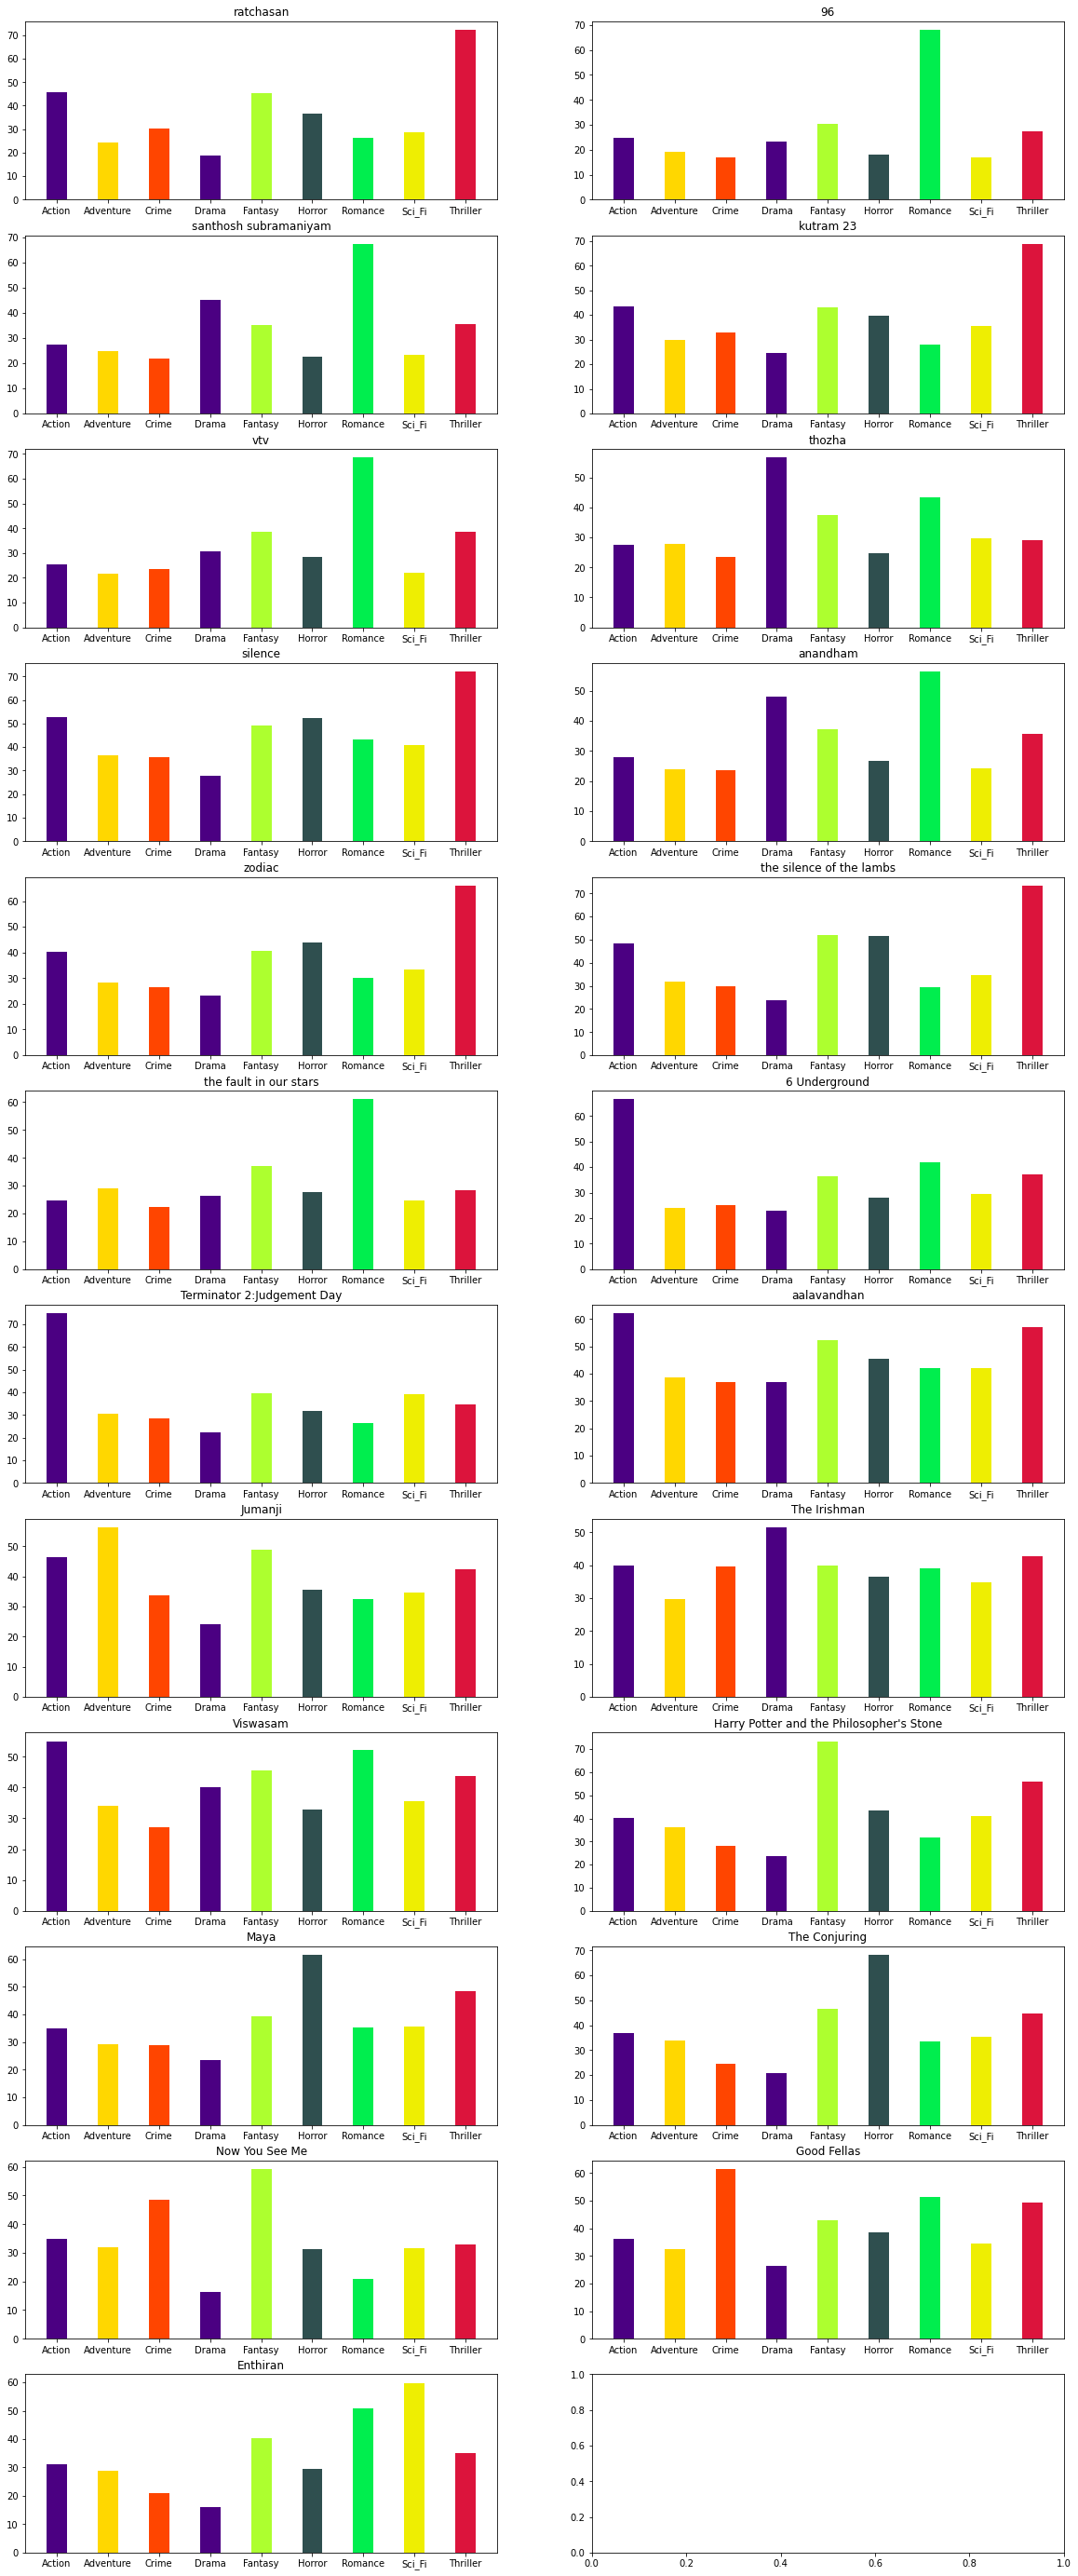

In [174]:
genre = ans.index.values
genre = [genre[i].title() for i in range(len(genre))]
fig, axs = plt.subplots(math.ceil(ans.shape[1]/2), 2,figsize = (20, 50))
count = 0
for i in ans.columns.values:
    nsix = ans[i] * 100
    axs[(count//2),count%2].bar(genre,nsix.values,color =color, width = 0.4)
    axs[(count//2),count%2].set_title(i)
    count+=1
plt.show()

In [17]:
pl = inp[inp.shape[0]-1:]['Plot_reduction'].values[0]
ti = inp[inp.shape[0]-1:]['title'].values[0]
ans = func5([pl],[ti])

In [18]:
ans

,Enthiran
action,0.311719
adventure,0.289319
crime,0.208363
drama,0.160400
fantasy,0.404438
horror,0.294726
romance,0.507992
sci_fi,0.598373
thriller,0.351287


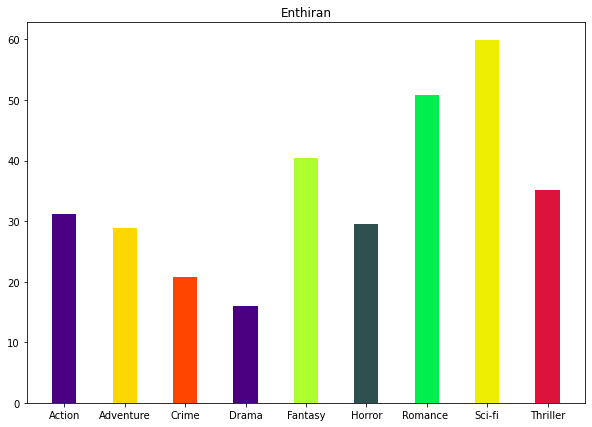

In [227]:
fig = plt.figure(figsize = (10, 7))
nsix = ans[ti].values*100
plt.bar(genre,nsix,color = color, width = 0.4)
plt.title(ti)
plt.show()


In [230]:
cons.index = ['enthiran','topic 1']

In [231]:
cons.T

,enthiran,topic 1
words,,
anoth,0.000000,0.089511
arriv,0.000000,0.081676
away,0.000000,0.100021
becom,0.180702,0.104046
begin,0.000000,0.102169
believ,0.000000,0.080221
dead,0.000000,0.095349
decid,0.000000,0.070258
die,0.000000,0.098429
